# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 306
  Number of variables: 408
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.13.2\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.20060205459594727
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0


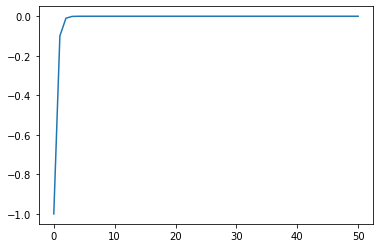

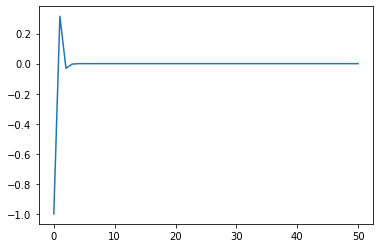

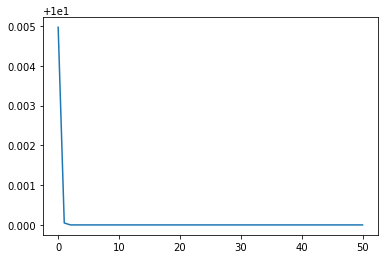

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numpy.linalg import norm
import pyomo.environ as pyo

N = 50
g = 9.81 # gravitational acceleration, m/s^2
m = 2.7/1000 # ball mass, kg
e = 0.9 # coeff of restitution
model = pyo.ConcreteModel()

nx = 3
nu = 2

model.tidx = pyo.Set(initialize=range(0, N+1)) # length of finite optimization problem
model.xidx = pyo.Set(initialize=range(0, nx))
model.uidx = pyo.Set(initialize=range(0, nu))


# create state trajectory variables
model.z = pyo.Var(model.xidx, model.tidx)
model.u = pyo.Var(model.uidx, model.tidx)
model.y = pyo.Var(model.tidx)
model.vb_post = pyo.Var(model.uidx, model.tidx)

x0 = np.array([-1, -1, -10])
yd = 10

model.obj = pyo.Objective(expr=sum((model.z[0, t])**2 + (model.y[t] - yd)**2 + (model.z[1, t])**2
                                    for t in model.tidx if t <= N), sense=pyo.minimize)

model.init_constraint = pyo.Constraint(model.xidx, rule=lambda model, i: model.z[i, 0] == x0[i])


model.vb1_post_constraint = pyo.Constraint(model.tidx, rule=lambda model, i: model.vb_post[0,i] == model.z[2,i]*(pyo.cos(model.u[1,i])*pyo.sin(model.u[1,i])
                                           + e*pyo.cos(model.u[1,i])*pyo.sin(model.u[1,i])) - model.z[1,i]*(e*(pyo.sin(model.u[1,i])**2) - pyo.cos(model.u[1,i])**2)
                                           - model.u[0,i]*(pyo.cos(model.u[1,i])*pyo.sin(model.u[1,i]) + e*pyo.cos(model.u[1,i])*pyo.sin(model.u[1,i])))
model.vb2_post_constraint = pyo.Constraint(model.tidx, rule=lambda model, i: model.vb_post[1,i] == model.z[2,i]*(pyo.sin(model.u[1,i])**2 - e*(pyo.cos(model.u[1,i])**2))
                                           + model.u[0,i]*(e*(pyo.cos(model.u[1,i])**2) - pyo.sin(model.u[1,i])**2 + 1)
                                           + model.z[1,0]*(pyo.cos(model.u[1,i])*pyo.sin(model.u[1,i]) + e*pyo.cos(model.u[1,i])*pyo.sin(model.u[1,i])))

model.output_constraint = pyo.Constraint(model.tidx, rule=lambda model, i: model.y[i] == 0.5*(model.vb_post[1, i]**2)/g)

model.state1_constraint = pyo.Constraint(model.tidx, rule=lambda model, i: model.z[0, i + 1] == model.z[0, i] + 2*model.vb_post[0, i]*model.vb_post[1, i]/g
                                         if i <= N - 1 else pyo.Constraint.Skip)
model.state2_constraint = pyo.Constraint(model.tidx, rule=lambda model, i: model.z[1, i + 1] == model.vb_post[0, i]
                                         if i <= N - 1 else pyo.Constraint.Skip)
model.state3_constraint = pyo.Constraint(model.tidx, rule=lambda model, i: model.z[2, i + 1] == -model.vb_post[1, i]
                                         if i <= N - 1 else pyo.Constraint.Skip)

results = pyo.SolverFactory('ipopt').solve(model).write()

z1 = [pyo.value(model.z[0,0])]
z2 = [pyo.value(model.z[1,0])]
y = [pyo.value(model.y[0])]
u1 = [pyo.value(model.u[0,0])]
u2 = [pyo.value(model.u[1,0])]

for t in model.tidx:
    if t < N:
        z1.append(pyo.value(model.z[0,t+1]))
        z2.append(pyo.value(model.z[1,t+1]))
        y.append(pyo.value(model.y[t+1]))
    if t < N-1:
        u1.append(pyo.value(model.u[0,t+1]))
        u2.append(pyo.value(model.u[1,t+1]))
        
plt.figure()
plt.plot(z1)
plt.figure()
plt.plot(z2)
plt.figure()
plt.plot(y)
plt.show()

[array([2.8563955])]
[array([], dtype=float64)]


IndexError: index 0 is out of bounds for axis 0 with size 0

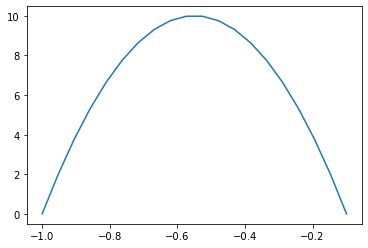

In [5]:
def ball_ode(t, x):
    # x = [x_b, y_b, vx_b, vy_b]
    return np.array([x[2], x[3], 0, -g])

def ball_bounce(t, x):
    return x[1]
    
ball_bounce.terminal = True
ball_bounce.direction = -1

N = 10
x_full = []

A = np.array([[1, 0], [0, -e]])
R = np.array([[np.cos(u2[0]), -np.sin(u2[0])], [np.sin(u2[0]), np.cos(u2[0])]])
A_bar = R@A@R.T
vp = np.array([0, u1[0]])
vb_0 = x0[1:3]
vb_0_post = (np.eye(2) - A_bar)@vp + A_bar@vb_0
z0 = np.array([x0[0], 0, vb_0_post[0], vb_0_post[1]])
plt.figure()
for i in range(N):
    sol = solve_ivp(ball_ode, (0, 100), z0, events=ball_bounce, dense_output=True)
    t = np.linspace(0, sol.t_events[0][0], 20)
    x = sol.sol(t)
    plt.plot(x[0], x[1])
    z0 = x[:,-1]
    R = np.array([[np.cos(u2[i+1]), -np.sin(u2[i+1])], [np.sin(u2[i+1]), np.cos(u2[i+1])]])
    A_bar = R@A@R.T
    vp = np.array([0, u1[i + 1]])
    vb_post = (np.eye(2) - A_bar)@vp + A_bar@z0[2:4]
    z0[2] = vb_post[0]
    z0[3] = vb_post[1]
    
plt.show()

